In [73]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
data = pd.read_csv("BCData.csv", header = None)
data_orig = data.copy()
X = data.iloc[:,2:]
y = data.iloc[:,1]
nFea = X.shape[1]

In [75]:
XM = X[y == "M"]
XB = X[y == "B"]
averageM = [0 for i in range(nFea)]
rangesM = [0 for i in range(nFea)]
for j in range(nFea):
    averageM[j] = XM.iloc[:,j].mean()
    rangesM[j] = XM.iloc[:,j].max() - XM.iloc[:,j].min() 
    #ranges = XM.iloc[:,j].std()
    XM.iloc[:,j] -= averageM[j]
    XM.iloc[:,j] = XM.iloc[:,j]/rangesM[j] 

averageB = [0 for i in range(nFea)]
rangesB = [0 for i in range(nFea)]
for j in range(XB.shape[1]):
    averageB[j] = XB.iloc[:,j].mean()
    rangesB[j] = XB.iloc[:,j].max() - XB.iloc[:,j].min() 
    #ranges = XM.iloc[:,j].std()
    XB.iloc[:,j] -= averageB[j]
    XB.iloc[:,j] = XB.iloc[:,j]/rangesB[j]

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [76]:
KM = 3
KB = 3

kmM = KMeans(n_clusters = KM,  random_state = 4)
kmM.fit(XM)
centroidM = kmM.cluster_centers_
labelsM = kmM.labels_
    
kmB = KMeans(n_clusters = KB,  random_state = 1)
kmB.fit(XB)
centroidB = kmB.cluster_centers_
labelsB = kmB.labels_    

In [77]:
'''
newDF = pd.DataFrame()
newDF['firstColumn'] = [1,2,3,4,-1]
newDF['secondColumn'] = [2,4,5,1,2]
newDF
newDF = pd.DataFrame(np.zeros((5, 4)))
newDF.dtypes
'''

"\nnewDF = pd.DataFrame()\nnewDF['firstColumn'] = [1,2,3,4,-1]\nnewDF['secondColumn'] = [2,4,5,1,2]\nnewDF\nnewDF = pd.DataFrame(np.zeros((5, 4)))\nnewDF.dtypes\n"

In [78]:
minXMj = np.zeros((KM, nFea))
maxXMj = np.zeros((KM, nFea))
maxDifM = np.zeros((KM, nFea))
for k in range(KM):
    XMtemp = XM[labelsM == k]
    for j in range(nFea):
        minXMj[k,j] = min(XMtemp.iloc[:,j])
        maxXMj[k,j] = max(XMtemp.iloc[:,j])
        maxDifM[k,j] =  max(abs(centroidM[k, j] - XMtemp.iloc[:,j]))

minXBj = np.zeros((KB, nFea))
maxXBj = np.zeros((KB, nFea))
maxDifB = np.zeros((KB, nFea))
for k in range(KB):
    XBtemp = XB[labelsB == k]
    for j in range(nFea):
        minXBj[k,j] = min(XBtemp.iloc[:,j])
        maxXBj[k,j] = max(XBtemp.iloc[:,j])
        maxDifB[k,j] =  max(abs(centroidB[k, j] - XBtemp.iloc[:,j]))


In [79]:
'''
print(minXMj[0,0])
print(maxXMj[0,0])
print(centroidM[0,0])
print(abs(centroidM[0,0] - maxXMj[0,0]))
print(abs(centroidM[0,0] - minXMj[0,0]))
print(maxDifM[0])
'''

'\nprint(minXMj[0,0])\nprint(maxXMj[0,0])\nprint(centroidM[0,0])\nprint(abs(centroidM[0,0] - maxXMj[0,0]))\nprint(abs(centroidM[0,0] - minXMj[0,0]))\nprint(maxDifM[0])\n'

In [80]:
nRows = X.shape[0]
Xnew = pd.DataFrame(np.zeros((nRows, KM + KB)))

for i in range(nRows):
    for k in range(KM):
        pc = 0
        for j in range(nFea):
            if(y[i] == "M"):
                Xij = (X.iloc[i,j] - averageM[j]) / rangesM[j]
            else:
                Xij = (X.iloc[i,j] - averageB[j]) / rangesB[j]
            if((minXMj[k,j] <= Xij) and (Xij <= maxXMj[k,j])):
                #if((minXMj[k,j] > centroidM[k,j]) or (centroidM[k,j] > maxXMj[k,j])):
                #    print("Centroid Error")
                f = abs(centroidM[k,j] - Xij)/maxDifM[k,j]
                if(f > 1.00001):
                    #print(f)
                    print("MFractional Error")
                pc = pc + (1-f)
        Xnew.iloc[i, k] = pc/nFea;
        
    for k in range(KB):
        pc = 0
        for j in range(nFea):
            if(y[i] == "M"):
                Xij = (X.iloc[i,j] - averageM[j]) / rangesM[j]
            else:
                Xij = (X.iloc[i,j] - averageB[j]) / rangesB[j]
            if((minXBj[k,j] <= Xij) and (Xij <= maxXBj[k,j])):
                f = abs(centroidB[k,j] - Xij)/maxDifB[k,j]
                if(f > 1.00001):
                    print("BFractional Error")
                pc = pc + (1-f)
        Xnew.iloc[i, KM+k] = pc/nFea;

In [81]:
from sklearn import metrics 
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

CRange = [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#CRange = [50]
trainError = [0 for i in range(len(CRange))]
testError = [0 for i in range(len(CRange))]
sensitivity = [0 for i in range(len(CRange))]
specificity = [0 for i in range(len(CRange))]
fittime = [0 for i in range(len(CRange))]

for i in range(len(CRange)):
    print(CRange[i])
    clf = SVC(C = CRange[i], kernel='linear')
    ypred = cross_val_predict(clf, Xnew, y, cv=10)
    scores = cross_validate(clf, Xnew, y, cv=10, return_train_score=True)
    #sorted(scores.keys())
    trainError[i] = scores['train_score'].mean()
    testError[i] = scores['test_score'].mean()
    fittime[i] = scores['fit_time'].mean()
    cm = metrics.confusion_matrix(y, ypred)
    sensitivity[i] = float(cm[1][1])/np.sum(cm[1])
    specificity[i] = float(cm[0][0])/np.sum(cm[0])
#metrics.confusion_matrix(y, ypred)
#metrics.accuracy_score(y, ypred)

0.1
1
10
20
30
40
50
60
70
80
90
100


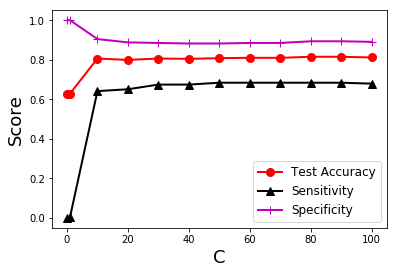

In [82]:
#plt.plot(CRange, trainError, '-*b')
plt.plot(CRange, testError, '-or', lw = 2, ms = 8)
plt.plot(CRange, sensitivity, '-^k', lw = 2, ms = 8)
plt.plot(CRange, specificity, '-+m', lw = 2, ms = 8)
plt.legend(['Test Accuracy', 'Sensitivity', 'Specificity'], fontsize = 12)
plt.xlabel("C", fontsize=18)
plt.ylabel("Score", fontsize=18)
plt.savefig('KSVM_Linear_Accuracy.png', format='png')
plt.savefig('KSVM_Linear_Accuracy.eps', format='eps')
#plt.savefig('KSVM_Sigmoid_Accuracy.png', format='png')
#plt.savefig('KSVM_Sigmoid_Accuracy.eps', format='eps')

In [83]:
fittime
#metrics.confusion_matrix(y, ypred)

[0.0039243221282958983,
 0.0042499303817749023,
 0.0040336132049560549,
 0.0047393083572387692,
 0.0043641567230224606,
 0.0048270463943481442,
 0.0047252178192138672,
 0.0056461095809936523,
 0.0050579547882080075,
 0.0055164098739624023,
 0.0058726072311401367,
 0.0058575391769409178]

1.4638501094227998

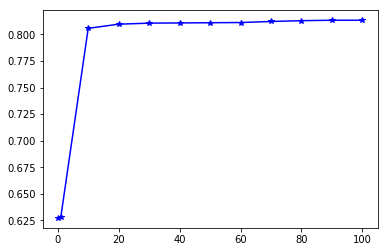

In [85]:
plt.plot(CRange, trainError, '-*b')
trainError[10]
testError[10]
2.5/(35/12)**0.5